<font size="5"> **DSCI 100 Project: Analysis of Facebook Posts Popularity and Interactions** </font>

<font size="3">**Introduction**</font>

Facebook, one of the top social media platforms, allows all its users to post content onto their account/feed whenever and whatever they like. For the purposes of this project, Facebook was used to reach an audience to build the cosmetics brand.

There are four post types a user can make:
> - Link: a status update with a link embedded.
> - Photo: an image posted with a caption elaborating on the image contents.
> - Status: short qualitative status
> - Video: video posted with a short caption.

We are acting as social media managers/marketers who are trying to promote this cosmetic brand. We want to find what kind of posts bring in the most views and interactions (likes, comments, shares) to our Facebook page. 

More specifically, we will be investigating:
> - (1) Which kind of post (link, photo, status, or video) is the most popular and which day is the most popular to post? 
> - (2) In answering the above question, we will begin a regression model to determine whether the post is performing well or underperforming.


These questions are important to answer as it will demonstrate how effective our current posting methods are and what changes are necessary. By learning what kinds of posts are popular, we can change our scheduling and content to maximize the value of each post. Our dataset is from the UCI Machine Learning Repository where it analyses 500 posts/pages with 19 variables. The data used originated from the Facebook metrics of a popular cosmetics brand. We will use this data to determine the most popular type of post determined by the number of total interactions. Using that information, we will filter for the most popular day and establish the success of a post using linear regression.
We expected the relationship in our regression model to be positive because as the number of views and impressions increase, then the total number of interactions will increase.

<font size="3">**Methods & Results:**</font>

>To begin, we loaded the libraries and the data from the original source on the web.

In [26]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
library(ggplot2)

In [27]:
activity_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip" #ICS Machine Learning Training set archive      
temp <- tempfile()                       #Vector of character strings to be used for naming temporary files, saved to temp.
download.file(activity_url, temp)        #Download Zip file from ICS archive, save into temp.
unzip(temp, "dataset_Facebook.csv")      #Unzip File.


fb_data <- read_delim("dataset_Facebook.csv",  #Read dataset and factor Type Column
                      ";") %>%                     
    mutate(Type = as.factor(Type))

unlink(temp)                            #Delete Temporary Vector

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)




>The column names in the data are changed to exclude spaces and to replace them with "." 
> The data is then wrangled and cleaned to include only relevant columns (Post.Weekday and Total.Interactions). These columns will be used for exploring the data.


In [28]:
#Tidying Data: Replace spaces in Column names with periods.
colnames(fb_data) <- make.names(colnames(fb_data))
    head(fb_data)

fb_data_eda <- fb_data %>%
    filter(Lifetime.Post.Total.Impressions < 30000) %>%
    select(Type, Post.Weekday, Total.Interactions) 
print("Table 1 - Facebook data for exploratory data analysis")

Page.total.likes,Type,Category,Post.Month,Post.Weekday,Post.Hour,Paid,Lifetime.Post.Total.Reach,Lifetime.Post.Total.Impressions,Lifetime.Engaged.Users,Lifetime.Post.Consumers,Lifetime.Post.Consumptions,Lifetime.Post.Impressions.by.people.who.have.liked.your.Page,Lifetime.Post.reach.by.people.who.like.your.Page,Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post,comment,like,share,Total.Interactions
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186


[1] "Table 1 - Facebook data for exploratory data analysis"


In [29]:
credit_summary <- fb_data_eda %>% 
    group_by(Type) %>% 
    summarize(n = n(),
              Median = median(Total.Interactions),
              Average = mean(Total.Interactions),
              Standard_Dev = sd(Total.Interactions))
print("Table 2 - Summary of data")
credit_summary

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 2 - Summary of data"


Type,n,Median,Average,Standard_Dev
<fct>,<int>,<dbl>,<dbl>,<dbl>
Link,17,48.0,63.17647,55.98798
Photo,346,104.5,135.13006,111.05057
Status,33,121.0,154.63636,90.29529


A visualization of the exploratory data analysis consisted of the weekday a post was posted and the total interactions it had. For the purposes of this section, interactions are defined as likes, comments, and shares. The visualization shows that Wednesday has the highest interaction count and that mainly photos are interacted with.


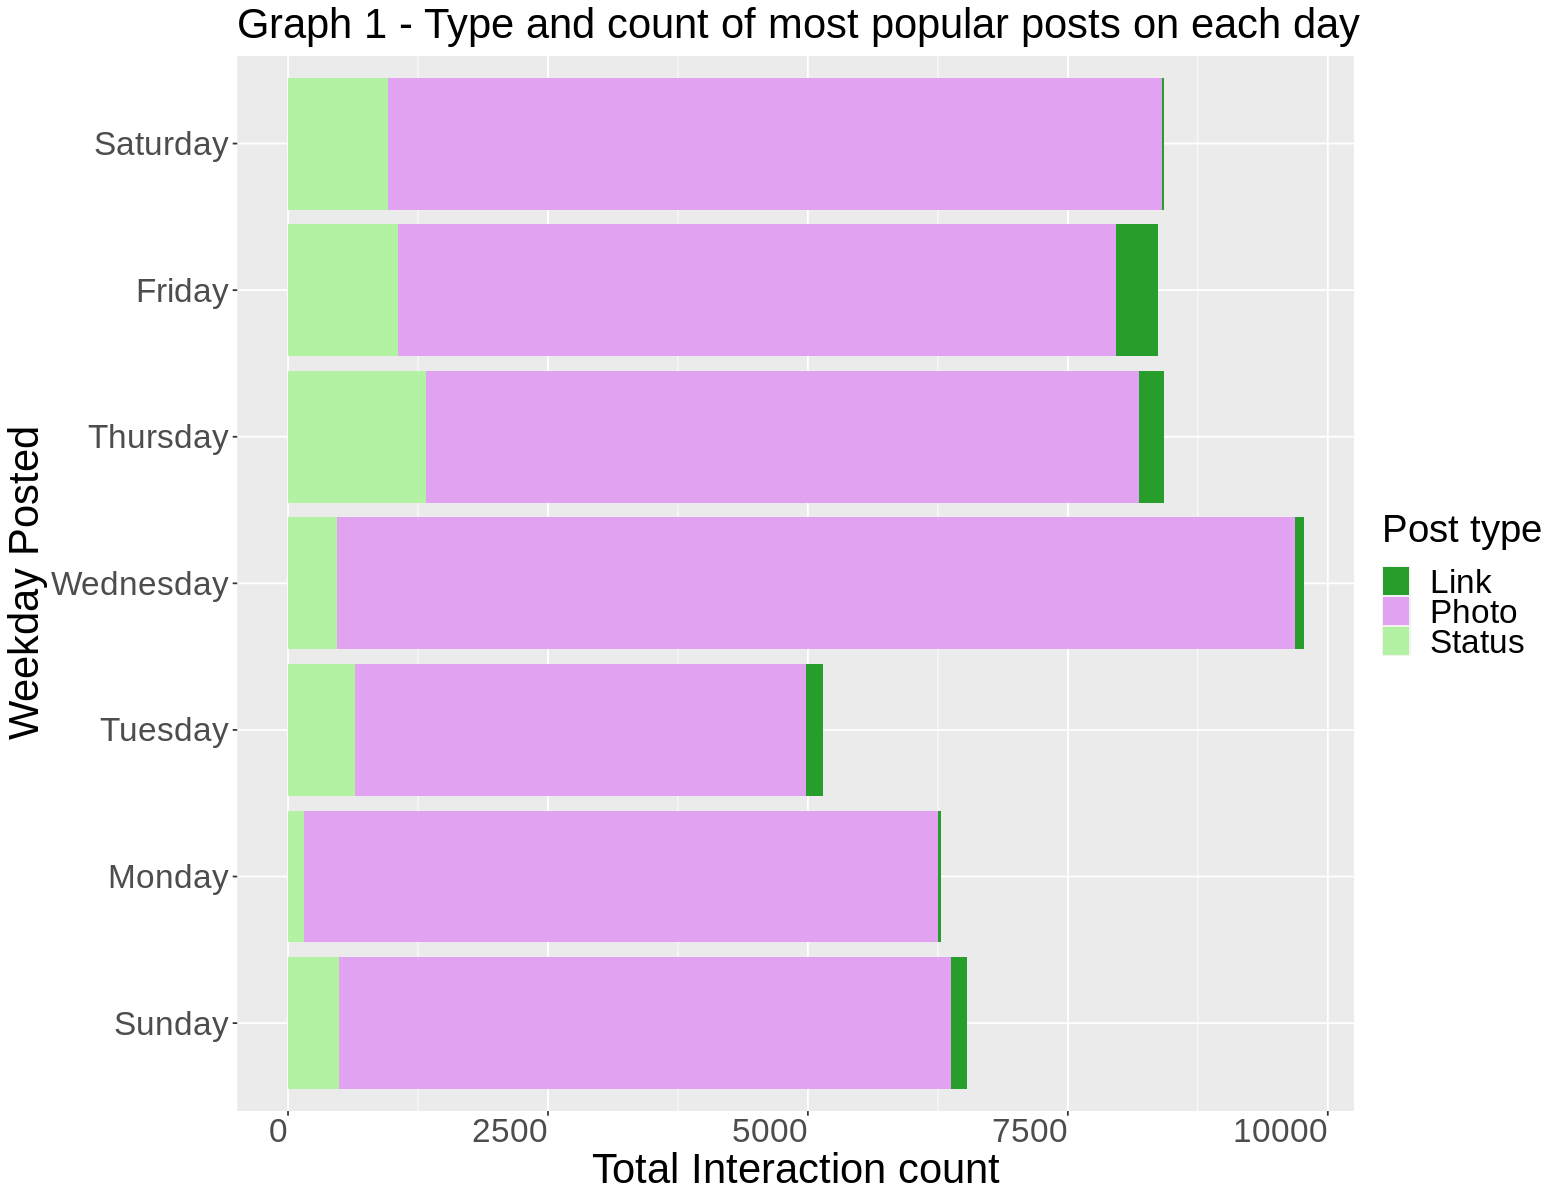

In [30]:
options(repr.plot.height = 10, repr.plot.width = 13)

most_interactions <- fb_data_eda %>%                                      #plot of interactions and post type vs day
    arrange(desc(Post.Weekday)) %>%
    ggplot(aes(x = Post.Weekday, 
                 y = Total.Interactions,                     
                 fill = Type)) + 
    geom_bar(stat = "identity") +                                         #graph titles
    xlab("Weekday Posted") +
    ylab("Total Interaction count") +
    labs(fill = "Post type") +
    ggtitle("Graph 1 - Type and count of most popular posts on each day") +
    theme(axis.text = element_text(size = 20,                             #font sizes
                                    hjust = 1),
         plot.title = element_text(size = 25),
         axis.title = element_text(size = 25),
         legend.text = element_text(size = 20),
         legend.title = element_text(size = 23)) +
scale_fill_manual(values = c("Link" = "#279E2B",
                               "Photo" = "#E1A3F1",
                               "Status" = "#B3F1A3")) +
scale_x_discrete(limits=c("1", "2", "3", "4", "5", "6", "7"),            #Changes originally x-axis labels from numeric to their respective days.
                  labels=c("1" = "Sunday",
                           "2" = "Monday",
                           "3" = "Tuesday",
                           "4" = "Wednesday",
                           "5" = "Thursday",
                           "6" = "Friday",
                           "7" = "Saturday" )) +
    coord_flip()
most_interactions

In [31]:
options(repr.plot.height = 10, repr.plot.width = 13)

fb_data <- fb_data %>%
    filter(Post.Weekday == "4") %>%                            #Filter for the day with the most interactions as determined above.
    select(Type, Lifetime.Post.Total.Impressions, like)        

fb_recipe <- recipe(Lifetime.Post.Total.Impressions ~ like, 
                    data = fb_data)

fb_recipe <- fb_recipe %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors()) %>%
  prep()

Further analysis uses the amount of likes and the lifetime post total impressions. Impressions are the number of times a post is viewed, regardless if it is the same consumer. The visualization below shows that photos and links have the highest lifetime post total impressions and likes.

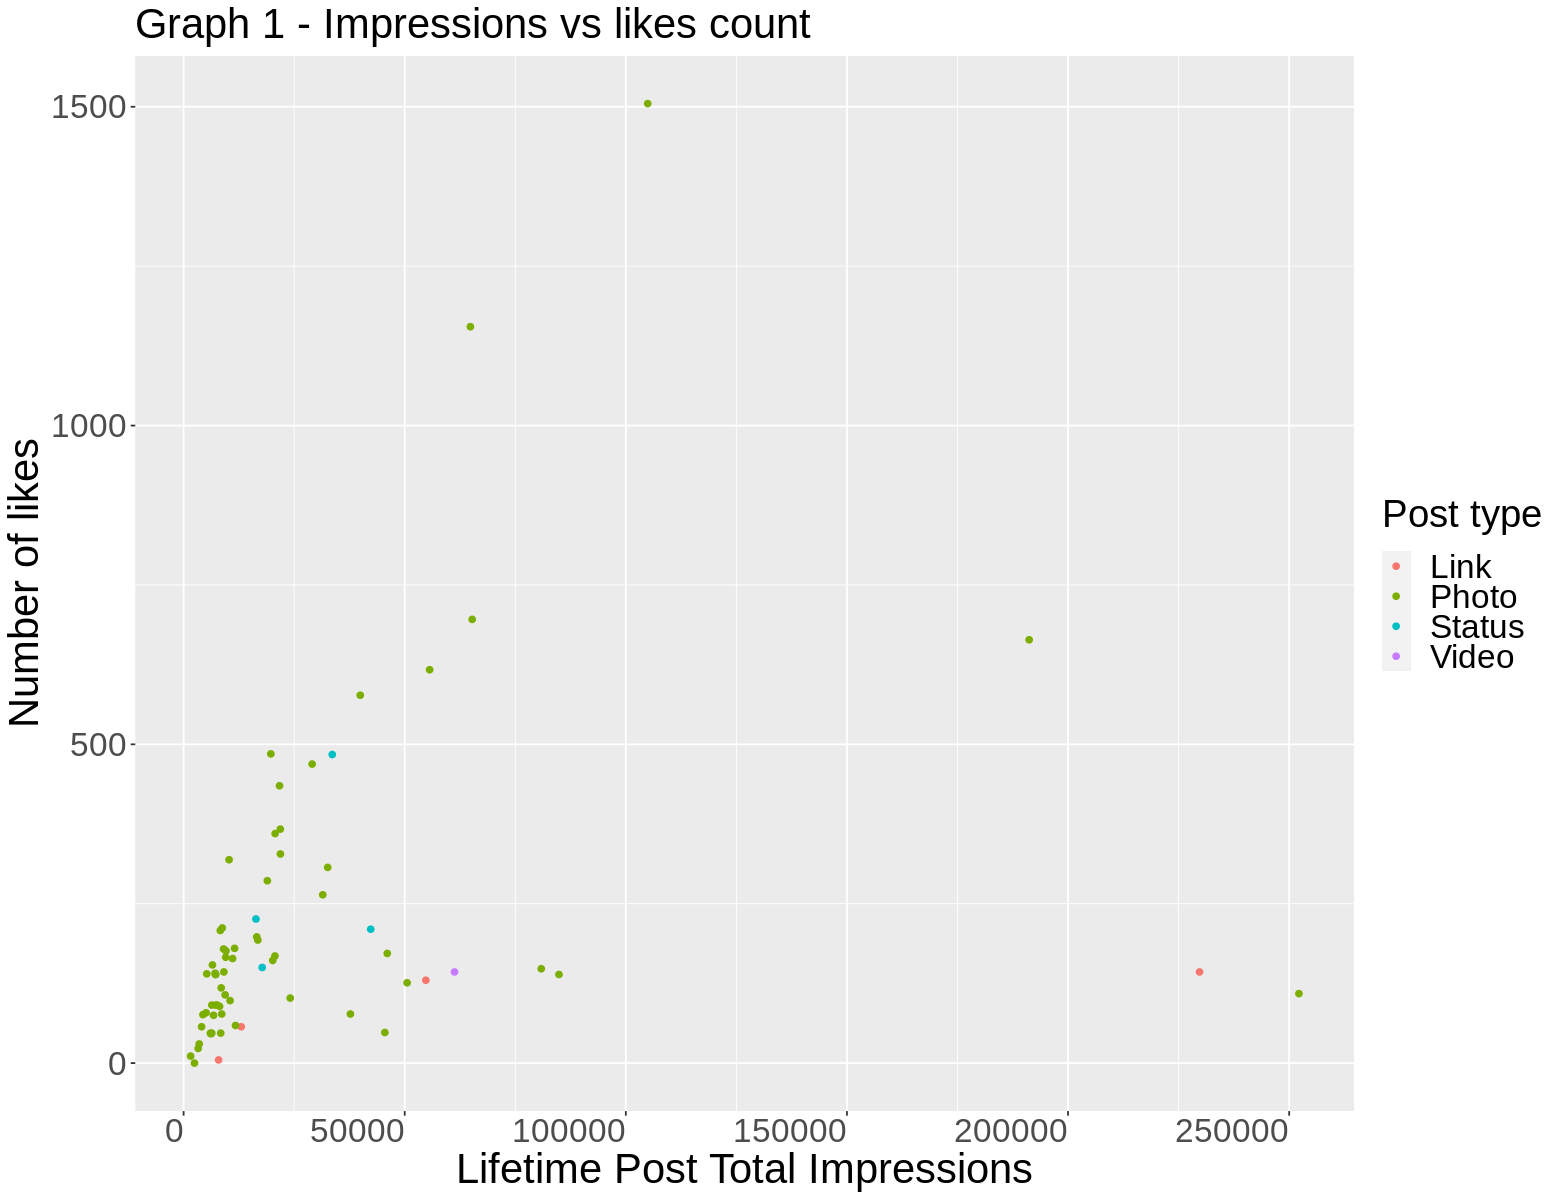

In [34]:
most_interactions <- fb_data %>%                                      #plot of interactions and post type vs day
    filter(Lifetime.Post.Total.Impressions < 300000) %>%
    ggplot(aes(x = like, 
                 y = Lifetime.Post.Total.Impressions,                     
                 colour = Type)) + 
    geom_point() +
 scale_fill_manual(values = c("Link" = "#279E2B",
                               "Photo" = "#E1A3F1",
                               "Status" = "#B3F1A3",
                                "Video" = "#266E83")) +               #graph titles
    ylab("Lifetime Post Total Impressions") +
    xlab("Number of likes") +
    labs(colour = "Post type") +
    ggtitle("Graph 1 - Impressions vs likes count") +
    theme(axis.text = element_text(size = 20,                         #font sizes
                                    hjust = 1),
         plot.title = element_text(size = 25),
         axis.title = element_text(size = 25),
         legend.text = element_text(size = 20),
         legend.title = element_text(size = 23)) +
   
coord_flip()
most_interactions

<font size="3">**Interpreting the results**</font>

To understand the implications of the data, we will use linear regression.

>The data is split into testing and training sets.

In [20]:
fb_split <- initial_split(fb_data,
                          prop = 0.65,
                          strata = Type)  #splitting data
fb_train <- training(fb_split)   
fb_test <- testing(fb_split)

>Using linear regression, the model was trained and tested to find the RMSE of the final model. The RMSE is about 1.086093e+05.


In [21]:
lm_spec <- linear_reg() %>%  
  set_engine("lm") %>%  
  set_mode("regression")

fb_recipe <- recipe(Lifetime.Post.Total.Impressions ~ like, ############
                    data = fb_train)

lm_fit <- workflow() %>%  
  add_recipe(fb_recipe) %>%  
  add_model(lm_spec) %>%  
  step_scale(all_predictors()) %>%
  step_center(all_predictors()) %>%
  fit(data = fb_train)
lm_fit

lm_test_results <- lm_fit %>%  
  predict(fb_test) %>%  
  bind_cols(fb_test) %>%  
  metrics(truth = Lifetime.Post.Total.Impressions,
          estimate = .pred)
lm_test_results

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)         like  
   42628.39        70.06  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.899912e+04
rsq,standard,2.910312e-01
mae,standard,3.596951e+04


To determine/ visualize whether the RMSE is "good", we plotted the lifetime post total impressions versus the amount of likes the post received. In doing so, we can predict at how many views we should be getting on a post at a certain amount of likes. If it is above the linear regression line then the post is gettting a lot of likes for the amount of views it is receiving. If it is below the linear regression line, the post is reaching a broad audience but it is not being well recieved. 

`geom_smooth()` using formula 'y ~ x'



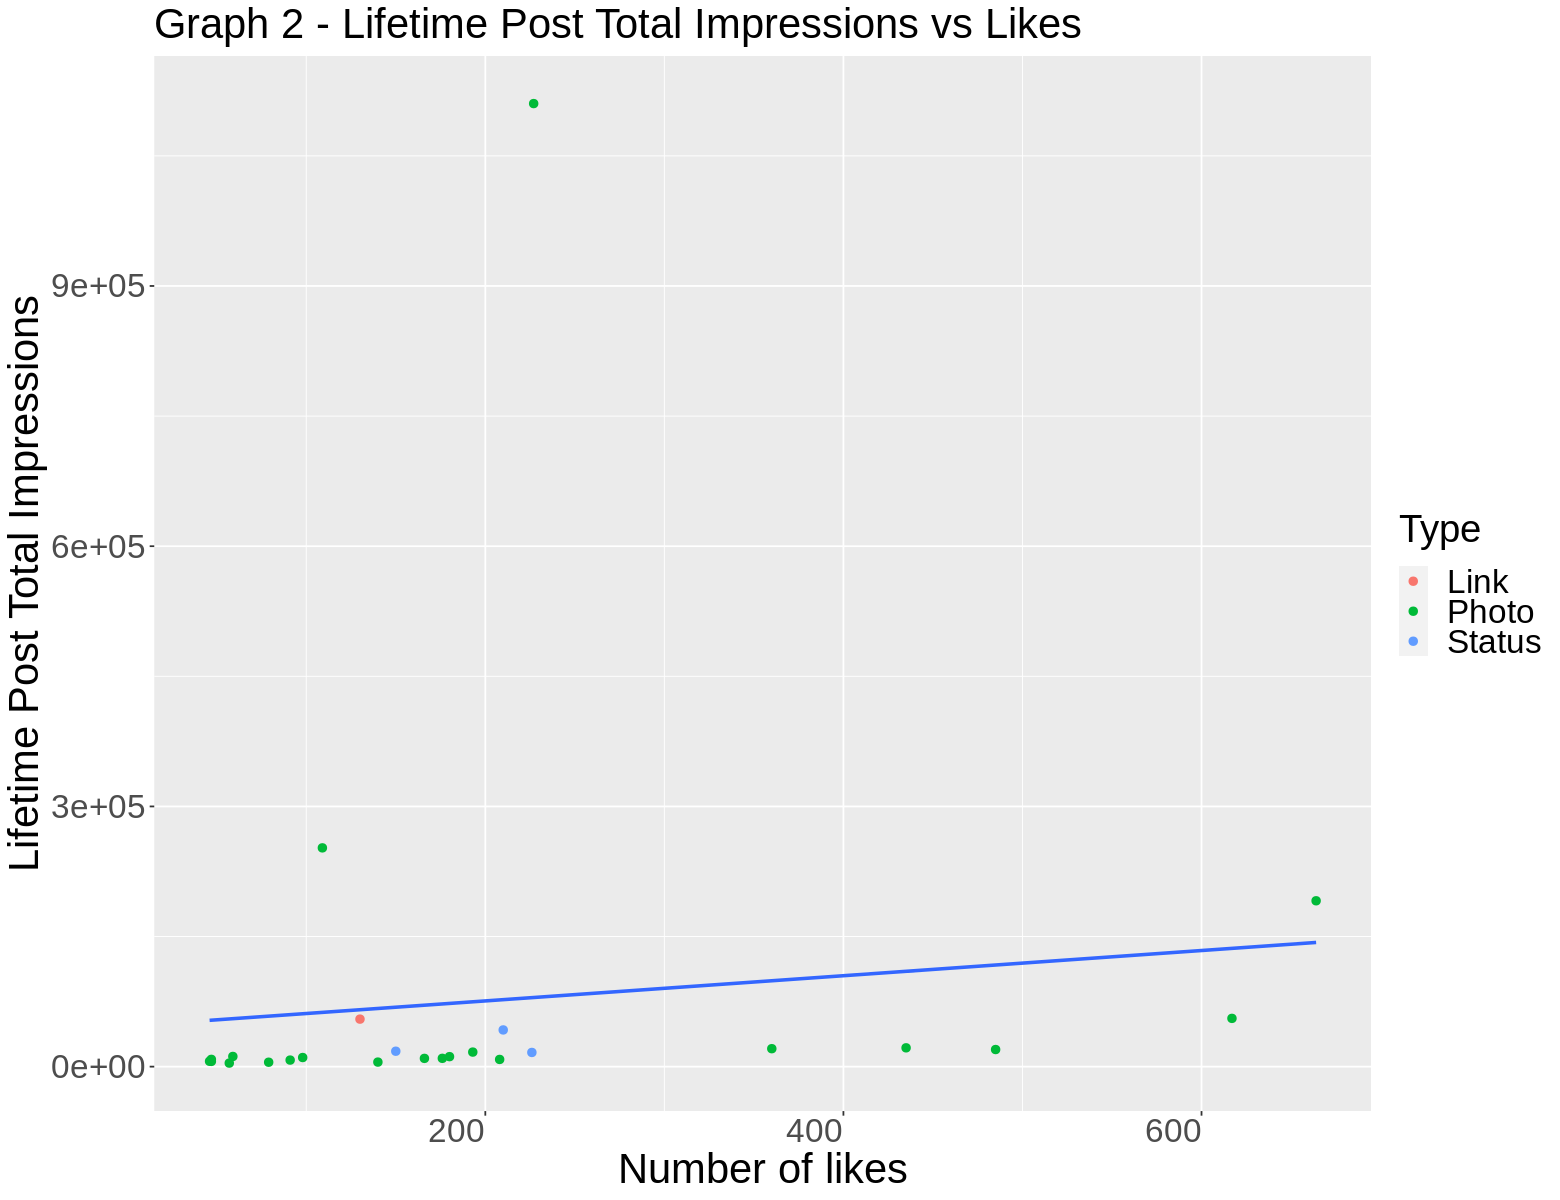

In [24]:
lm_plot_final <- ggplot(fb_test, aes(x = like,
                                     y = Lifetime.Post.Total.Impressions)) +
  geom_point(alpha = 1, aes(colour = Type), size = 2) +
scale_fill_manual(values = c("Link" = "#FF0000",
                               "Photo" = "#E1A3F1",
                               "Status" = "#B3F1A3",
                                "Video" = "#266E83")) +
    xlab("Number of likes") +
  ylab("Lifetime Post Total Impressions") +
    ggtitle("Graph 2 - Lifetime Post Total Impressions vs Likes") +
    theme(axis.text = element_text(size = 20,                         #font sizes
                                    hjust = 1),
         plot.title = element_text(size = 25),
         axis.title = element_text(size = 25),
         legend.text = element_text(size = 20),
         legend.title = element_text(size = 23)) +
  geom_smooth(method = "lm", se = FALSE)
lm_plot_final

The findings are consistent with are expecations because **##########**

<font size="3">**Discussion:**</font>

######insert discussion here######

<font size="3">**References:**</font>

> - Moro, S., Rita, P., & Vala, B. (2016, February 28). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research. https://www.sciencedirect.com/science/article/abs/pii/S0148296316000813
> - Glossary of metrics - analytics - facebook. Help & Support. (n.d.). https://support.socialbakers.com/hc/en-us/articles/115007663707-Glossary-of-Metrics-Analytics-Facebook-
> - UCI machine Learning REPOSITORY: Facebook metrics data set. (n.d.). https://archive.ics.uci.edu/ml/datasets/Facebook+metrics


In [25]:
text

function (x, ...) 
UseMethod("text")
<bytecode: 0x55f424aebc00>
<environment: namespace:graphics>